# **StratFusion: RAG-Based Investment Intelligence Engine**

### **Background Story**
In modern investment analysis, financial performance metrics such as stock growth, revenue trends, and market capitalization provide only part of the picture. While these quantitative indicators reflect current momentum and stability, they do not fully capture an organization’s future readiness—particularly its strategic positioning in emerging technologies such as Artificial Intelligence (AI).

At the same time, qualitative sources such as annual reports, innovation strategy documents, and technical disclosures contain valuable insights about long-term vision and AI adoption. However, these documents are unstructured, difficult to query, and rarely integrated systematically with financial data.

The Strategic Intelligence Ranking Engine (RAG-Based) was designed to bridge this gap.

The system integrates:


*   Quantitative financial data (e.g., stock performance trends from Yahoo Finance)
*   Qualitative strategic insights extracted from organizational reports (PDFs)
*   Retrieval-Augmented Generation (RAG) to ground reasoning in contextual evidence

By combining structured financial indicators with retrieved strategic signals, the engine produces a unified ranking of organizations based on both financial strength and innovation readiness.

Rather than treating numerical growth and strategic initiatives as separate analytical dimensions, this system merges them into a single, AI-driven evaluation pipeline—enabling a more holistic and forward-looking investment assessment.

### **Problem Statement**

Traditional investment analysis primarily relies on quantitative financial indicators such as stock growth, revenue trends, and market capitalization. While these metrics reflect current performance, they provide limited visibility into an organization's long-term innovation capacity and technological readiness.

Conversely, qualitative sources—such as strategic reports and AI initiative disclosures—offer insight into future positioning but are unstructured, difficult to query, and not easily integrated with numerical financial data.

This separation creates three systemic challenges:

Fragmented Data Sources
Financial time-series data and strategic documents exist in independent silos, preventing unified analysis.

Limited Analytical Integration
Quantitative metrics and qualitative insights are rarely evaluated within a single decision framework, resulting in incomplete assessments.

Forward-Looking Blind Spots
Without combining growth trends with innovation signals, investors risk underestimating organizations with strong long-term strategic positioning.

The core problem, therefore, is not a lack of data—but the absence of a structured mechanism to integrate heterogeneous financial and strategic signals into a unified evaluation model.

### **Solution Approach**
To address this challenge, we set out to build a **Retrieval-Augmented Generation (RAG)** powered system that blends financial trends with AI-related strategic insights, helping investors rank organizations based on growth trajectory and innovation capacity.

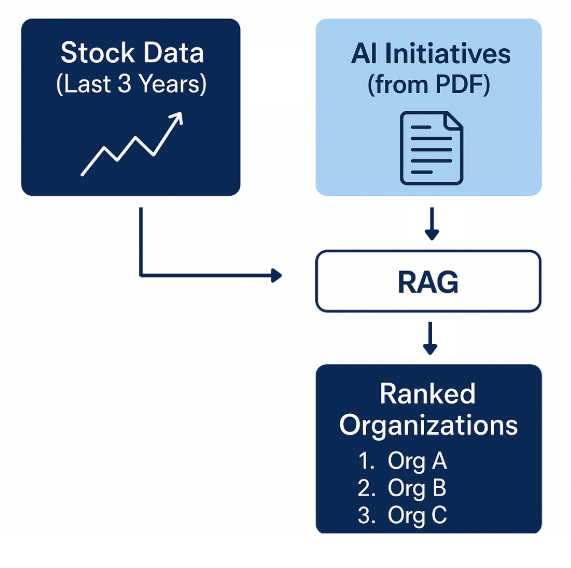

#**Setting up Installations and Imports**

In [ ]:
# @title

! uv pip install langchain \
                langchain-core \
                langchain-openai \
                chromadb \
                langchain-community \
                pypdf

Using Python 3.12.12 environment at: /usr
Resolved 115 packages in 4.43s
Prepared 25 packages in 3.97s
Uninstalled 2 packages in 10ms
Installed 25 packages in 150ms
 + backoff==2.2.1
 + bcrypt==5.0.0
 + chromadb==1.3.5
 + coloredlogs==15.0.1
 + dataclasses-json==0.6.7
 + durationpy==0.10
 + httptools==0.7.1
 + humanfriendly==10.0
 + kubernetes==34.1.0
 + langchain-community==0.3.31
 + langchain-openai==0.3.35
 + marshmallow==3.26.1
 + mmh3==5.2.0
 + mypy-extensions==1.1.0
 + onnxruntime==1.23.2
 + opentelemetry-exporter-otlp-proto-grpc==1.37.0
 + posthog==5.4.0
 + pybase64==1.4.2
 + pypdf==6.3.0
 + pypika==0.48.9
 - requests==2.32.4
 + requests==2.32.5
 + typing-inspect==0.9.0
 - urllib3==2.5.0
 + urllib3==2.3.0
 + uvloop==0.22.1
 + watchfiles==1.1.1


In [ ]:
import yfinance as yf              # Used for gathering stock prices
import matplotlib.pyplot as plt    # Used for Data Visualization / Plots / Graphs
import pandas as pd                # Helpful for working with tabular data like DataFrames
import os                          # Interacting with the operating system

from langchain.text_splitter import RecursiveCharacterTextSplitter      #  Helpful in splitting the PDF into smaller chunks

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader     # Loading a PDF
from langchain_community.vectorstores import Chroma    # Vector DataBase

#**1. Organization Selection**

Selecting the below five organizations as the analysis pool.



In [ ]:
companies = ["GOOGL", "MSFT", "IBM", "NVDA", "AMZN"]

#**2. Setting up LLM**

- The `config.json` file should contain **API_KEY** and **API BASE URL** provided by OpenAI.
- You need to insert your actual API keys and endpoint URL obtained from your Olympus account. Refer to the **OpenAI Access Token documentation** for more information on how to generate and manage your API keys.
- This code reads the `config.json` file and extracts the API details.
  - The `API_KEY` is a **unique secret key** that authorizes your requests to OpenAI's API.
  - The `OPENAI_API_BASE` is the **API BASE URL** where the model will process your requests.

In [ ]:
#Loading the `config.json` file
import json
import os

# Load the JSON file and extract values
file_name = "config.json"
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="gpt-4o-mini",                    # "gpt-4o-mini" to be used as an LLM
    temperature=0,                          # Set the temprature to 0
    max_tokens=5000,                        # Set the max_tokens = 5000, so that the long response will not be clipped off
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

#**3. Visualization and Insight Extraction**

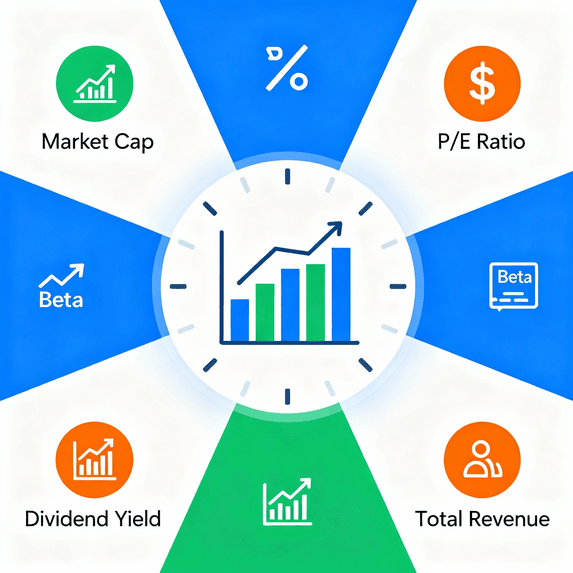

Here, we gather stock data for the selected organization from the past three years using the YFinance library, and visualize this data for enhanced analysis.


1. We loop through each company to retrieve stock data of the last three years using the YFinance library.
And,
2. We plot the closing prices for each company.

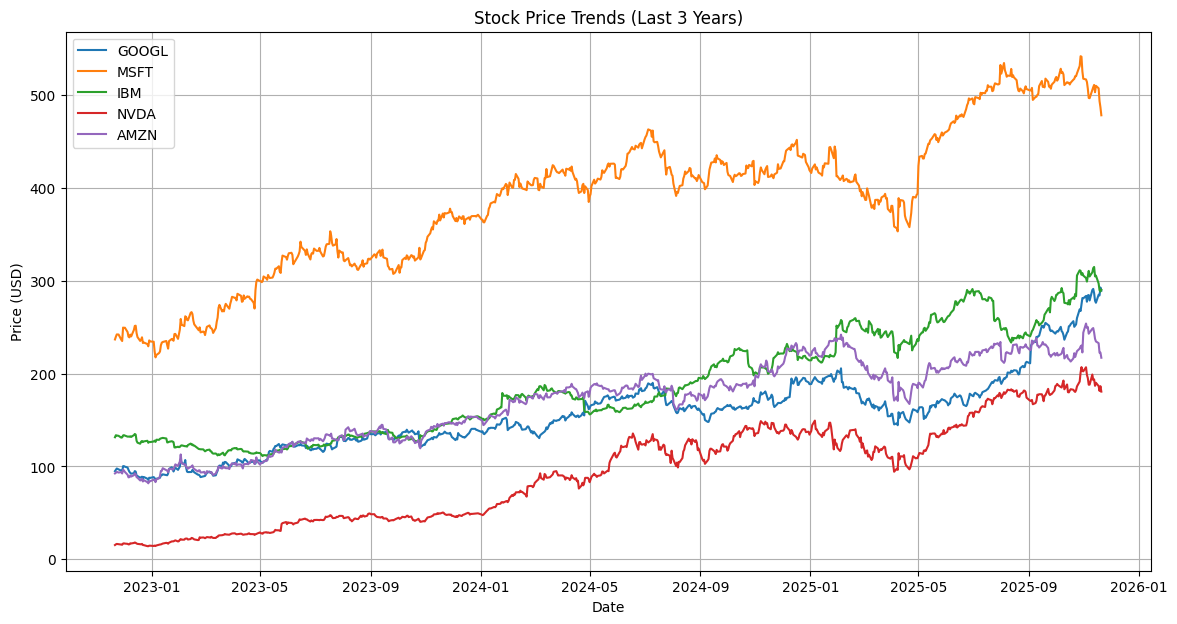

In [ ]:
plt.figure(figsize=(14,7))

# Loop through each company and plot closing prices
for symbol in companies:
    ticker = yf.Ticker(symbol)
    data = ticker.history(period="3y")

    # Plot closing price
    plt.plot(data.index, data['Close'], label=symbol)

plt.title("Stock Price Trends (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig("Stock_Price_Trends_3Y.png")
plt.show()

#### **Financial Metrics**

1. **Market Cap:** Total market value of a company’s outstanding shares.
2. **P/E Ratio:** Shows how much investors are willing to pay per dollar of earnings.
3. **Dividend Yield:** Annual dividend income as a percentage of the stock price.
4. **Beta**: Measures a stock’s volatility relative to the overall market.
5. **Total Revenue:** The total income a company generates from its business operations.





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

companies = ["GOOGL", "MSFT", "IBM", "NVDA", "AMZN"]
metrics_list = {}

# Fetching the financial metrics
for symbol in companies:                          # Loop through all the companies
    ticker = yf.Ticker(symbol)
    info = ticker.info
    metrics_list[symbol] = {                              # Define the dictionary of all the Finanical Metrics
        "Market Cap": info.get("marketCap", 0),
        "P/E Ratio": info.get("trailingPE", 0),
        "Dividend Yield": info.get("dividendYield", 0),
        "Beta": info.get("beta", 0),
        "Total Revenue": info.get("totalRevenue", 0)
    }

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(metrics_list).T

# Converting large numbers to billions for readability by divinding the whole column by 1e9
df["Market Cap"] = df["Market Cap"] / 1e9
df["Total Revenue"] = df["Total Revenue"] / 1e9
df["Dividend Yield"] = df["Dividend Yield"] * 100  # Convert to percentage

df   # Printing the df

,Market Cap,P/E Ratio,Dividend Yield,Beta,Total Revenue
GOOGL,3505.853825,28.573545,29.0,1.082,385.476002
MSFT,3556.249698,33.979404,75.0,1.065,293.812011
IBM,271.447114,34.571430,233.0,0.688,65.401999
NVDA,4405.368193,44.602467,2.0,2.269,165.217993
AMZN,2321.273586,30.669493,0.0,1.368,691.330023


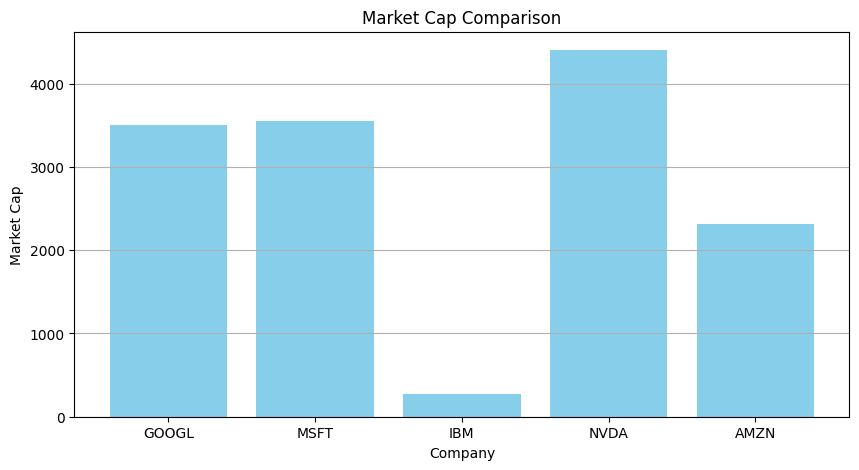

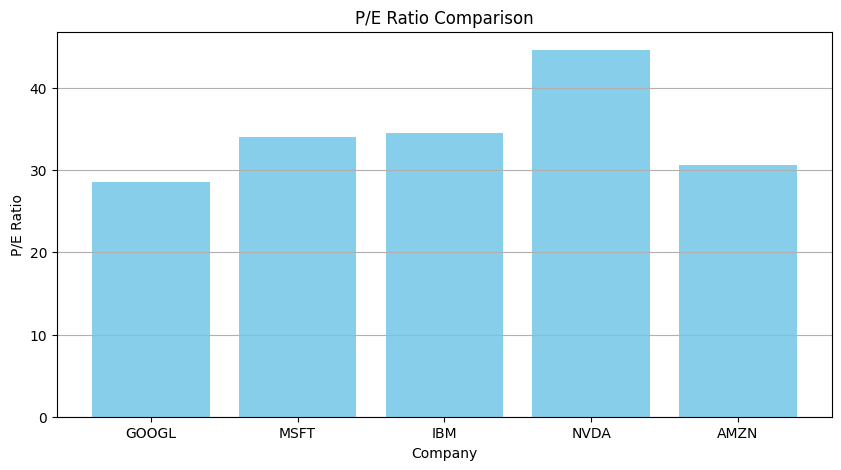

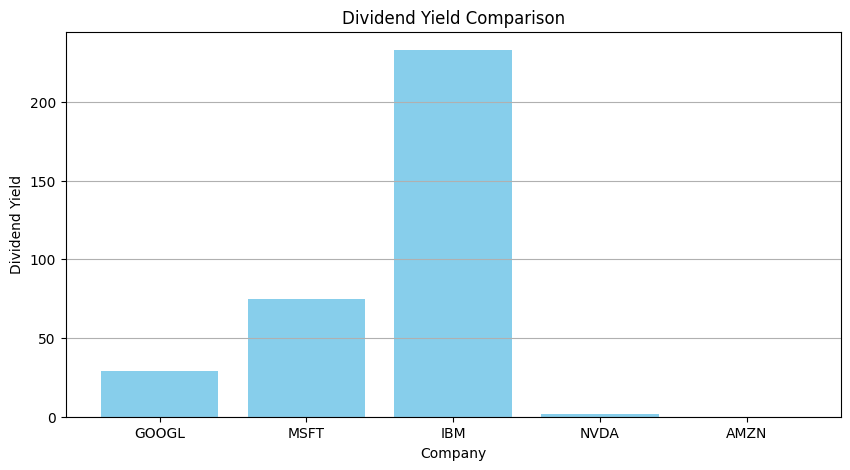

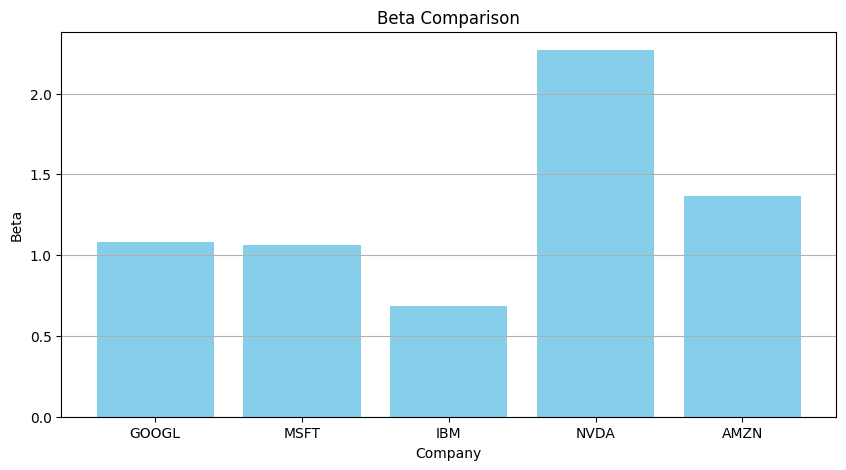

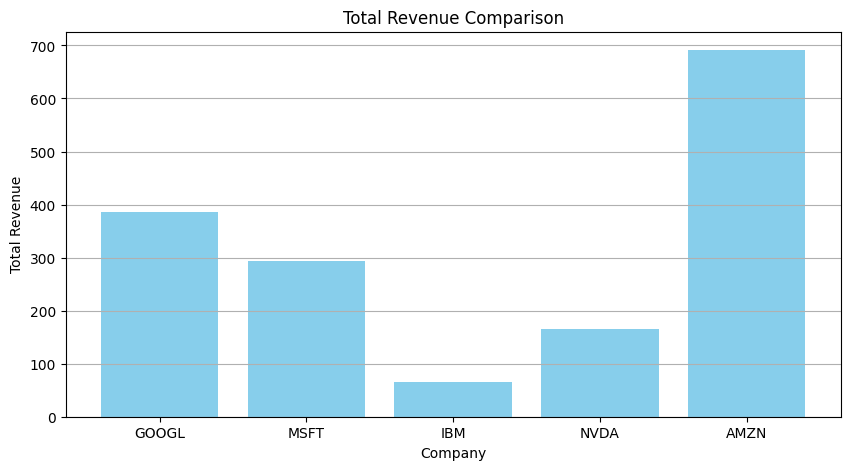

In [ ]:
# Plot each metric as a separate bar graph
metrics_to_plot = ["Market Cap", "P/E Ratio", "Dividend Yield", "Beta", "Total Revenue"]

for metric in metrics_to_plot:
    plt.figure(figsize=(10,5))
    plt.bar(df.index, df[metric], color='skyblue')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("Company")
    plt.grid(axis='y')
    plt.show()


#**4. RAG-Driven Analysis**

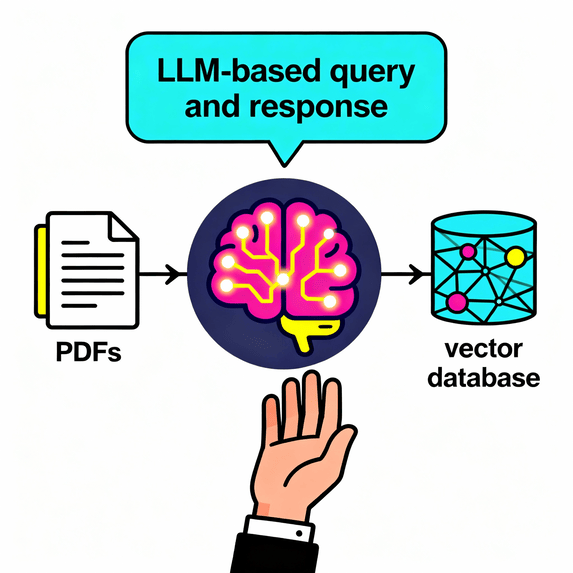

### **A. Loading Company AI Initiative Documents (PDFs)**

In [ ]:
# Unzipping the AI Initiatives Documents
import zipfile
with zipfile.ZipFile("Companies-AI-Initiatives.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/")         # Storing all the unzipped contents in this location

In [ ]:
# Path of all AI Initiative Documents
ai_initiative_pdf_paths = [f"/content/Companies-AI-Initiatives/{file}" for file in os.listdir("/content/Companies-AI-Initiatives")]
ai_initiative_pdf_paths

['/content/Companies-AI-Initiatives/IBM.pdf',
 '/content/Companies-AI-Initiatives/MSFT.pdf',
 '/content/Companies-AI-Initiatives/GOOGL.pdf',
 '/content/Companies-AI-Initiatives/AMZN.pdf',
 '/content/Companies-AI-Initiatives/NVDA.pdf']

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader(path = "/content/Companies-AI-Initiatives/")          # Creating an PDF loader object

In [ ]:
# Defining the text splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=50
)

In [ ]:
# Splitting the chunks using the text splitter
ai_initiative_chunks = loader.load_and_split(text_splitter)

In [ ]:
# Total length of all the chunks
len(ai_initiative_chunks)

106

### **B. Vectorizing AI Initiative Documents with ChromaDB**


In [ ]:
# Defining the 'text-embedding-ada-002' as the embedding model
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")

In [ ]:
#  Creating a Vectorstore, storing all the above created chunks using an embedding model
vectorstore = Chroma.from_documents(
    ai_initiative_chunks,
    embedding_model,
    collection_name="AI_Initiatives"
)

# Ignore if it gives an error or warning

In [ ]:
# Creating an retriever object which can fetch ten similar results from the vectorstore
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k":10}
)

### **C. Retrieving relevant Documents**

In [ ]:
user_message = "Give me the best project that `IBM` company is working upon"

In [ ]:
# Building the context for the query using the retrieved chunks
relevant_document_chunks = retriever.get_relevant_documents(user_message)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

In [ ]:
len(relevant_document_chunks)

10

In [ ]:
# Write a system message for an LLM to help craft a response from the provided context
qna_system_message = """
You are an assistant whose task is to analyze the provided report excerpts and generate accurate responses based solely on the available context.

The input will contain a section labeled ###Context, which includes relevant segments from company documents.

The user’s query will follow the token: ###Question.

Answers should be derived strictly from the provided context. Do not reference or mention the context explicitly in the response.

If the answer cannot be found within the context, respond with: "I don't know".

"""

In [ ]:
# Write an user message template which can be used to attach the context and the questions
qna_user_message_template = """
###Context
Here are some documents that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

In [ ]:
# Format the prompt
formatted_prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_message)}
                [/INST]"""

In [ ]:
# Make the LLM call
resp = llm.invoke(formatted_prompt)
resp.content

'The best project that IBM is currently working on is the Granite initiative, which involves a series of open-source, high-performance AI foundation models designed to empower enterprise applications across various industries. This project aims to provide efficient and customizable AI models that can be seamlessly integrated into operations, democratizing access to advanced AI technologies for businesses of all sizes.'

In [ ]:
# Define RAG function
def RAG(user_message):
    """
    Args:
    user_message: Takes a user input for which the response should be retrieved from the vectorDB.
    Returns:
    relevant context as per user query.
    """
    relevant_document_chunks = retriever.get_relevant_documents(user_message)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = ". ".join(context_list)



    # Combine qna_system_message and qna_user_message_template to create the prompt
    prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_message)}
                [/INST]"""

    # Quering the LLM
    try:
        response = llm.invoke(prompt)

    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response.content

In [ ]:
# Test Cases
print(RAG("How is the area in which GOOGL is working different from the area in which MSFT is working?"))

Google is focused on enhancing user experience and automating workflows through its AI ecosystem, which includes natural language processing, computer vision, speech recognition, and generative AI across various consumer products like Google Search and Google Assistant. In contrast, Microsoft emphasizes productivity enhancement in enterprise solutions through its AI capabilities integrated into applications like Word and Excel. While both companies are involved in AI research and development, Google's approach leans more towards consumer-facing applications while Microsoft's efforts are heavily geared towards enterprise solutions.


In [ ]:
print(RAG("What are the three projects on which MSFT is working upon?"))

I don't know.


In [ ]:
print(RAG("What is the timeline of each project in NVDA?"))

The timeline for each project in NVIDIA is as follows:

**DLSS:**
- **DLSS 1 (2018):** Initial AI upscaling, limited adoption due to artifacts.
- **DLSS 2 (2020):** Major breakthrough with temporal data, widespread game support.
- **DLSS 3 (2022):** Introduced frame generation, improving perceived smoothness but with challenges like ghosting.
- **DLSS 4 (2024–2025):** Current generation, refining frame generation and expanding integration with Reflex and advanced motion prediction. As of 2025, DLSS 4 is fully available and integrated into many new AAA titles.

**Project G-Assist:**
- **Concept & Demo Phase:** Early prototypes were teased in NVIDIA showcases tied to RTX AI initiatives.
- **Public Availability:** G-Assist became accessible via the NVIDIA App in 2024–2025. It remains labeled as experimental during its active development phase.


In [ ]:
print(RAG("What are the areas in which AMZN is investing when it comes to AI?"))

Amazon is investing in several areas related to AI, including:

1. **Generative AI**: Through initiatives like Amazon Bedrock and Olympus, which focus on enhancing capabilities in generative artificial intelligence.
2. **AI Services Expansion**: Complementing existing offerings such as SageMaker and Lex with platforms specifically designed for generative AI applications.
3. **Search Functionalities**: Improving search capabilities across various platforms to enhance user engagement and satisfaction.
4. **Ecosystem Partnerships**: Strengthening collaborations within the AI community by integrating foundational models from various companies.
5. **Infrastructure Development**: Allocating substantial resources to build the necessary infrastructure for advanced AI solutions.

These investments aim to bolster Amazon's position in the competitive landscape of AI technologies while enhancing its cloud services division.


In [ ]:
print(RAG("What are the risks associated with projects within GOOG?"))

The risks associated with projects within Google include:

1. **Model Safety**: Hallucinations and factual inaccuracies remain a risk, requiring constant evaluation and moderation.
2. **Privacy Concerns**: Processing live video and audio data raises significant privacy issues, necessitating robust data protection measures.
3. **Technical Hurdles**: Achieving real-time, accurate multimodal understanding requires overcoming complex AI and hardware challenges.
4. **User Acceptance**: Gaining user trust and acceptance for a new form of AI assistant that interacts in more personal and potentially intrusive ways is challenging.
5. **Regulatory Compliance**: Navigating the evolving landscape of AI regulations and ensuring compliance with global standards is necessary.
6. **AI-generated Code Risks**: There may be incorrect or vulnerable code generated by AI tools, along with concerns about intellectual property due to training on public repositories.
7. **Overreliance by Developers**: This may

### **D. Evaluation of the RAG**

In [ ]:
# Writing a question for performing evaluations on the RAG
evaluation_test_question = "What are the three projects on which MSFT is working upon?"

In [ ]:
# Building the context for the evaluation test question using the retrieved chunks
relevant_document_chunks = retriever.get_relevant_documents(evaluation_test_question)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

In [ ]:
# Default RAG Answer
answer = RAG(evaluation_test_question)
print(answer)

I don't know.


In [ ]:
# Defining user messsage template for evaluation
evaluation_user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

##### **1. Groundedness**

In [ ]:
# Writing the system message and the evaluation metrics for checking the groundedness
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.


"""

In [ ]:
# Combining groundedness_rater_system_message + llm_prompt + answer for evaluation
groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
            {'user'}: {evaluation_user_message_template.format(context=context_for_query, question=evaluation_test_question, answer=answer)}
            [/INST]"""

In [ ]:
# Defining a new LLM object
groundness_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

# Using the LLM-as-Judge for evaluating Groundedness
groundness_response = groundness_checker.invoke(groundedness_prompt)
print(groundness_response.content)

### Steps to Evaluate the Answer
1. **Identify the Question**: Understand what is being asked in the question.
2. **Review the Context**: Read through the provided context to extract relevant information regarding Microsoft's projects.
3. **Analyze the AI Generated Answer**: Compare the answer given by AI with both the question and context to see if it aligns with or derives from that information.
4. **Determine Adherence to Metric**: Assess whether or not (and how well) the answer follows the metric of being derived solely from context.

### Step-by-Step Explanation
1. The question asks for "the three projects on which MSFT is working upon."
2. The context provides detailed information about various initiatives Microsoft is involved in, including:
   - AI model development and fine-tuning
   - Cloud infrastructure integration with Microsoft Graph
   - Enterprise support, training, and onboarding 
   - Ongoing R&D for performance improvements 
   - Specific mention of Microsoft 365 Cop

##### **2. Relevance**

In [ ]:
# Writing the system message and the evaluation metrics for checking the relevance
relevance_rater_system_message = """
You are tasked with rating the relevance of context used by an AI system.
You will be presented with a question and the context used to answer it.
In the input, the question will begin with ###Question and the context will begin with ###Context.

Evaluation criteria:
The task is to judge the extent to which the context is relevant to the question.
1 - The context is not relevant at all
2 - The context is relevant only to a limited extent
3 - The context is relevant to a good extent
4 - The context is mostly relevant
5 - The context is completely relevant

Metric:
Context Relevance measures how well the provided context aligns with and supports answering the question.
Consider whether the context contains the necessary information to properly answer the question.

Instructions:
1. First write down the steps that are needed to evaluate the context relevance.
2. Give a step-by-step explanation of how the context relates to the question.
3. Next, evaluate the extent to which the context supports answering the question.
4. Use the previous information to rate the context using the evaluation criteria and assign a score.

"""

In [ ]:
# Combining relevance_rater_system_message + llm_prompt + answer for evaluation
relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
            {'user'}: {evaluation_user_message_template.format(context=context_for_query, question=evaluation_test_question, answer=answer)}
            [/INST]"""

In [ ]:
# Defining a new LLM object
relevance_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

# Using the LLM-as-Judge for evaluating Relevance
relevance_response = relevance_checker.invoke(relevance_prompt)
print(relevance_response.content)

### Steps to Evaluate Context Relevance
1. **Identify the Question**: Understand what information is being requested in the question.
2. **Analyze the Context**: Read through the provided context to extract relevant details that could answer the question.
3. **Match Information**: Determine if and how the information in the context relates directly to answering the question.
4. **Assess Completeness**: Evaluate whether all necessary aspects of a complete answer are covered by the context.
5. **Rate Relevance**: Use a scoring system (1-5) based on how well aligned and supportive of an answer to the question is.

### Step-by-Step Explanation
1. The question asks for "the three projects on which MSFT is working upon." This indicates that specific project names or descriptions are needed.
2. The context discusses various initiatives related to Microsoft, including AI model development, Microsoft 365 Copilot, Azure AI Foundry Labs, and other AI-related projects but does not explicitly list 

#**5. Scoring and Ranking**

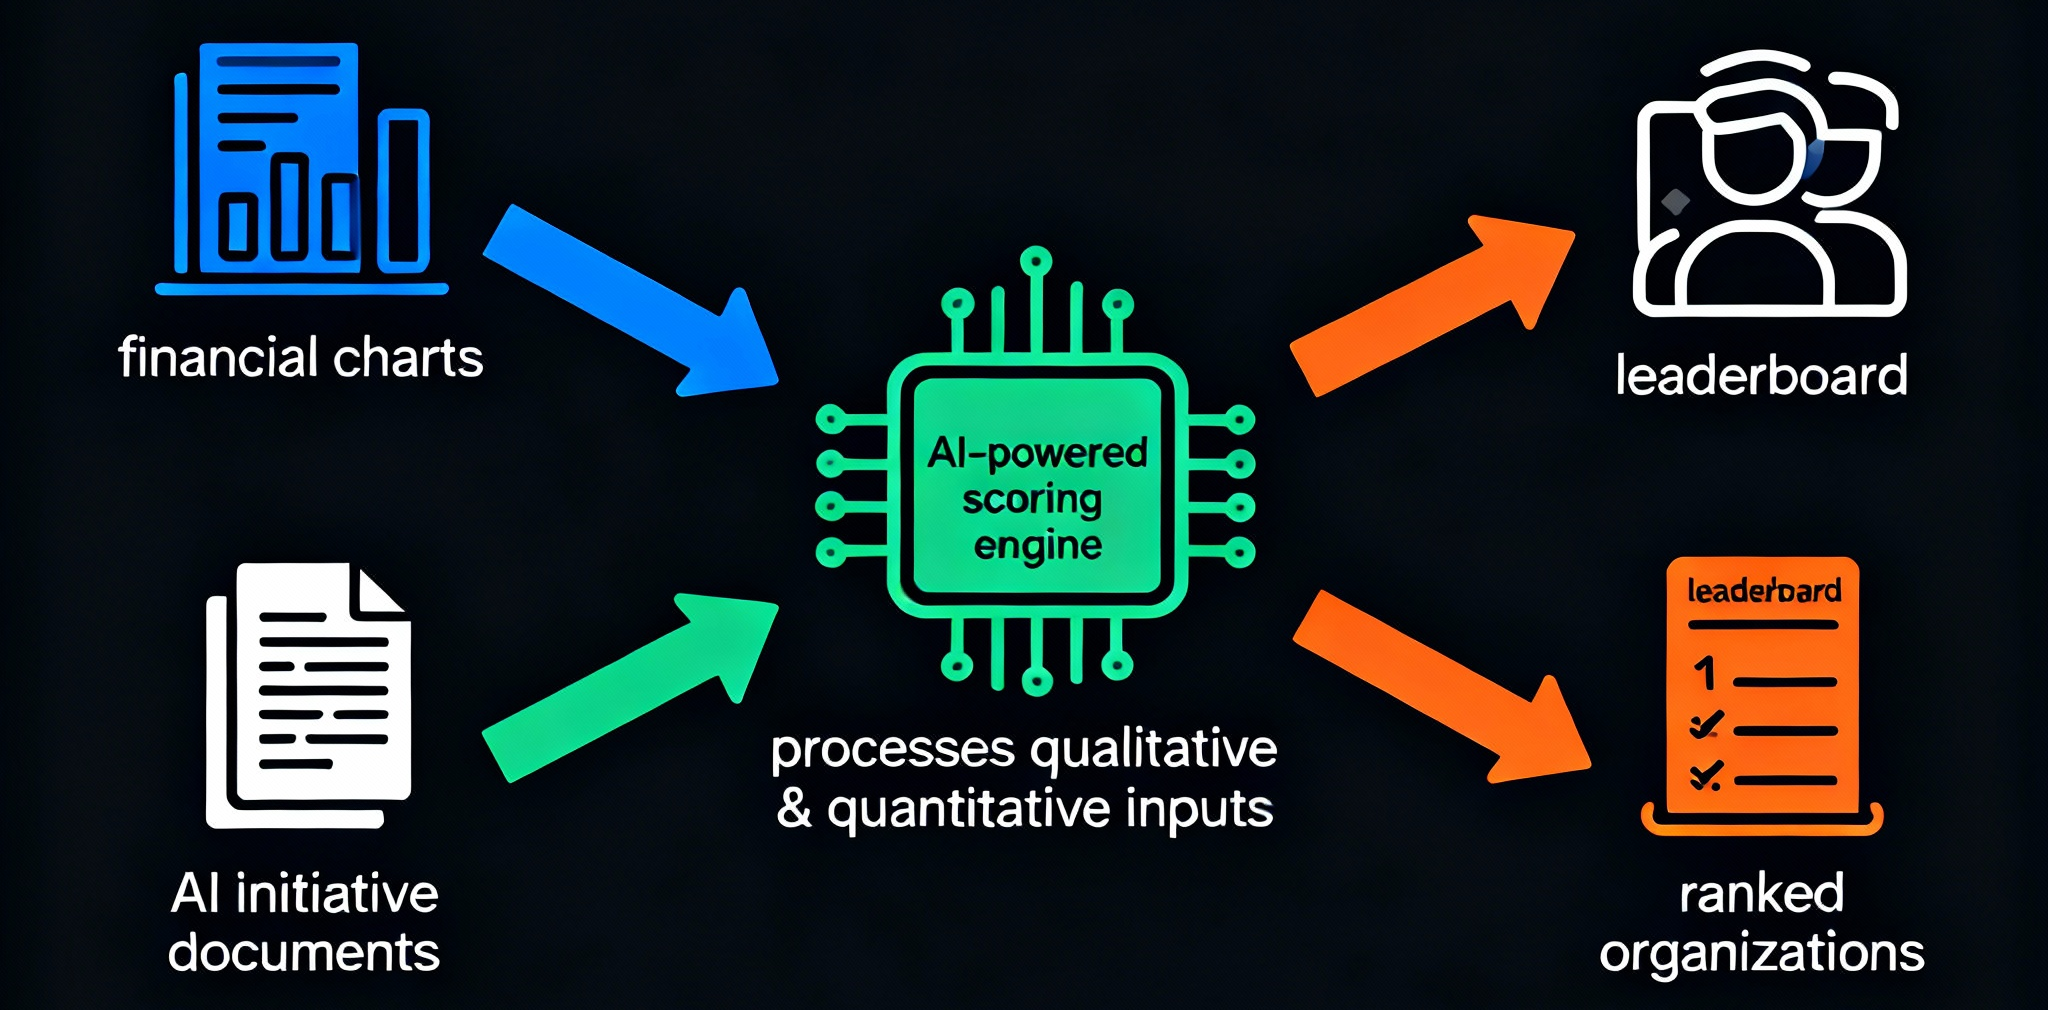

Here, we are prompting an LLM to score each company by integrating Quantitative data (stock trend, growth metrics) and Qualitative evidence (PDF insights)

1. We write a system message and a user message that outlines the required data for the prompt. And,
2. We Prompt the LLM to rank and recommend companies for investment based on the provided PDF and stock data to achieve better returns.

In [ ]:
# Fetching all the links of the documents
len(vectorstore.get()['documents'])

212

In [ ]:
# Write a system message for instructing the LLM for scoring and ranking the companies
system_message = """
You are an analytical assistant tasked with evaluating and ranking companies
based on two data sources:

1. Financial Data (market metrics such as Market Cap, P/E Ratio, Dividend Yield, Beta, and Revenue)
2. AI Initiative Documents (summaries extracted from company AI initiative PDFs)

Your objective is to recommend which company represents the strongest investment
opportunity for superior future returns.

Evaluation Criteria:
- Overall financial strength and growth potential.
- Quality, scale, and maturity of AI initiatives.
- Alignment between AI strategy and long-term value creation.
- Competitive advantage driven by AI capabilities.
- Risk factors visible in either financials or AI documentation.

Instructions:
1. Analyze both the financial table and the AI initiative text.
2. Score each company from 1–10 on:
   a. Financial performance
   b. AI innovation strength
   c. Long-term growth potential
3. Provide a ranked list of companies from strongest to weakest investment option.
4. Justify each ranking with brief, evidence-based reasoning from the provided data.
5. Do not use any external knowledge—only the data presented here.


 """

In [ ]:
# Write a user message for instructing the LLM for scoring and ranking the companies
user_message = f"""

You are provided with two sources of information:

---
### 1. Financial Data
{df.to_string()}

---
### 2. AI Initiatives
{vectorstore.get()['documents']}

Using ONLY the information above, analyze, score, and rank the companies as investment opportunities.
"""

In [ ]:
# Formatting the prompt
formatted_prompt = f"""[INST]{system_message}\n
                {'user'}: {user_message}
                [/INST]"""

In [ ]:
# Calling the LLM
recommendation = llm.invoke(formatted_prompt)
recommendation.content

"### Company Evaluation and Scoring\n\n#### 1. **Google (GOOGL)**\n- **Financial Performance**: 8/10\n  - Market Cap: $3,505.85B\n  - P/E Ratio: 28.57 (healthy but not the lowest)\n  - Dividend Yield: 29% (high yield indicates strong returns)\n  \n- **AI Innovation Strength**: 9/10\n   - Strong initiatives like Gemini and Vertex AI show advanced capabilities in multimodal AI.\n   - Significant investment in research and development.\n\n- **Long-term Growth Potential**: 9/10\n   - Continuous integration of AI across products enhances user engagement and productivity.\n   - Strategic alignment with market needs for generative AI.\n\n#### Total Score for Google = **26/30**\n\n---\n\n#### 2. **Microsoft (MSFT)**\n- **Financial Performance**: 7/10\n    - Market Cap: $3,556.25B \n    - P/E Ratio is higher at around ~34, indicating a premium valuation.\n    - High dividend yield of ~75%, suggesting strong cash flow management.\n\n- **AI Innovation Strength**: 8/10 \n    - Initiatives like Azu

In [ ]:
print(recommendation.content)

### Company Evaluation and Scoring

#### 1. **Google (GOOGL)**
- **Financial Performance**: 8/10
  - Market Cap: $3,505.85B
  - P/E Ratio: 28.57 (healthy but not the lowest)
  - Dividend Yield: 29% (high yield indicates strong returns)
  
- **AI Innovation Strength**: 9/10
   - Strong initiatives like Gemini and Vertex AI show advanced capabilities in multimodal AI.
   - Significant investment in research and development.

- **Long-term Growth Potential**: 9/10
   - Continuous integration of AI across products enhances user engagement and productivity.
   - Strategic alignment with market needs for generative AI.

#### Total Score for Google = **26/30**

---

#### 2. **Microsoft (MSFT)**
- **Financial Performance**: 7/10
    - Market Cap: $3,556.25B 
    - P/E Ratio is higher at around ~34, indicating a premium valuation.
    - High dividend yield of ~75%, suggesting strong cash flow management.

- **AI Innovation Strength**: 8/10 
    - Initiatives like Azure Foundry Labs and Microsof